In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf,read_raw_edf,read_raw_gdf
from mne.datasets import eegbci
from mne.decoding import CSP

Extracting EDF parameters from c:\Users\asus\Desktop\Motorimagery_for_gamification\dataset\bci_dataset\train\A03T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 660529  =      0.000 ...  2642.116 secs...


C:\Users\asus\anaconda3\envs\tf_gpu\lib\site-packages\mne\io\edf\edf.py:996: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
<ipython-input-56-c859e69017e6>:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw = concatenate_raws([read_raw_gdf(test_path, preload=True)])


<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | EEG-Fz, EEG-0, EEG-1, EEG-2, EEG-3, EEG-4, EEG-5, ...
    chs : list | 25 items (EEG: 25)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.5 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 100.0 Hz
    meas_date : tuple | 2004-11-09 12:00:00 GMT
    nchan : int | 25
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 250.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name 

<ipython-input-56-c859e69017e6>:29: RuntimeWarning: event 5 missing from event_id will be ignored
  fig = mne.viz.plot_events(events, sfreq=raw_data.info['sfreq'],
<ipython-input-56-c859e69017e6>:29: RuntimeWarning: event 6 missing from event_id will be ignored
  fig = mne.viz.plot_events(events, sfreq=raw_data.info['sfreq'],
<ipython-input-56-c859e69017e6>:29: RuntimeWarning: event 7 missing from event_id will be ignored
  fig = mne.viz.plot_events(events, sfreq=raw_data.info['sfreq'],
<ipython-input-56-c859e69017e6>:29: RuntimeWarning: event 8 missing from event_id will be ignored
  fig = mne.viz.plot_events(events, sfreq=raw_data.info['sfreq'],
<ipython-input-56-c859e69017e6>:29: RuntimeWarning: event 9 missing from event_id will be ignored
  fig = mne.viz.plot_events(events, sfreq=raw_data.info['sfreq'],
<ipython-input-56-c859e69017e6>:29: RuntimeWarning: event 10 missing from event_id will be ignored
  fig = mne.viz.plot_events(events, sfreq=raw_data.info['sfreq'],


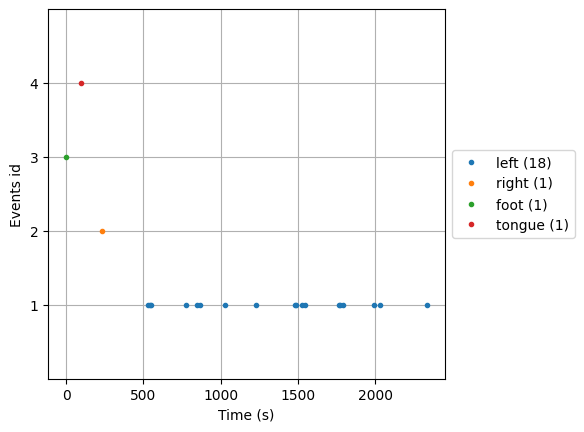

21 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 21 events and 1126 original time points ...
1 bad epochs dropped


In [56]:
def get_data():
    path = "dataset\\bci_dataset\\train"
    test_path = "dataset\\bci_dataset\\train\\A03T.gdf"
    files = os.listdir(path)
    data_path = []
    for f in files:
        file = os.path.join(path,f)
        data_path.append(file)
        
    
    tmin, tmax = -0.5, 4.
    event_id = dict(left=1, right = 2, foot=3,tongue=4)

    #raw = concatenate_raws([read_raw_gdf(f, preload=True) for f in data_path])
    raw = concatenate_raws([read_raw_gdf(test_path, preload=True)])
    raw_data = raw.copy()
    print(raw_data.info)
    # strip channel names of "." characters
    raw_data.rename_channels(lambda x: x.strip('.'))

    # Apply band-pass filter
    #skip_by_annotation='edge'
    raw_data.filter(l_freq=0.5, h_freq=None, method = 'iir', skip_by_annotation='edge')
    raw_data.notch_filter(50)

    events, _ = events_from_annotations(raw_data)
    print(events)
    #ploting
    fig = mne.viz.plot_events(events, sfreq=raw_data.info['sfreq'],
                          first_samp=raw_data.first_samp, event_id=event_id)
    
    
    picks = pick_types(raw_data.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')
    #delete eog band
    picks = np.delete(picks,[22,23,24])
    
    # Read epochs (train will be done only between 1 and 2s)
    #reject_criteria = dict( eeg=100e-6)       # 100 µV
    # Testing will be done with a running classifier
    epochs = Epochs(raw_data, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None,preload=True)
    epochs.crop(tmin=1., tmax=None)
    labels = epochs.events[:, 2] -1
    return epochs.get_data()[:, :, :256], labels,epochs,raw_data


epochs_data, labels,epochs1,raw= get_data()

In [55]:
# 280 events
# 22 channel
# 256 Time

print(epochs_data.shape)
print(labels.shape)
print(epochs_data.shape[1])
print(labels)
print(raw.info)


(20, 22, 256)
(20,)
22
[3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | EEG-Fz, EEG-0, EEG-1, EEG-2, EEG-3, EEG-4, EEG-5, ...
    chs : list | 25 items (EEG: 25)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.5 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 100.0 Hz
    meas_date : tuple | 2004-11-09 12:00:00 GMT
    nchan : int | 25
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 250.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : None

<Epochs  |   20 events (all good), 1 - 4 sec, baseline off, ~2.6 MB, data loaded,
 'foot': 0
 'left': 18
 'right': 1
 'tongue': 1>


C:\Users\asus\anaconda3\envs\tf_gpu\lib\site-packages\mne\viz\epochs.py:1031: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  params['fig'].canvas.set_window_title(title or 'Epochs')


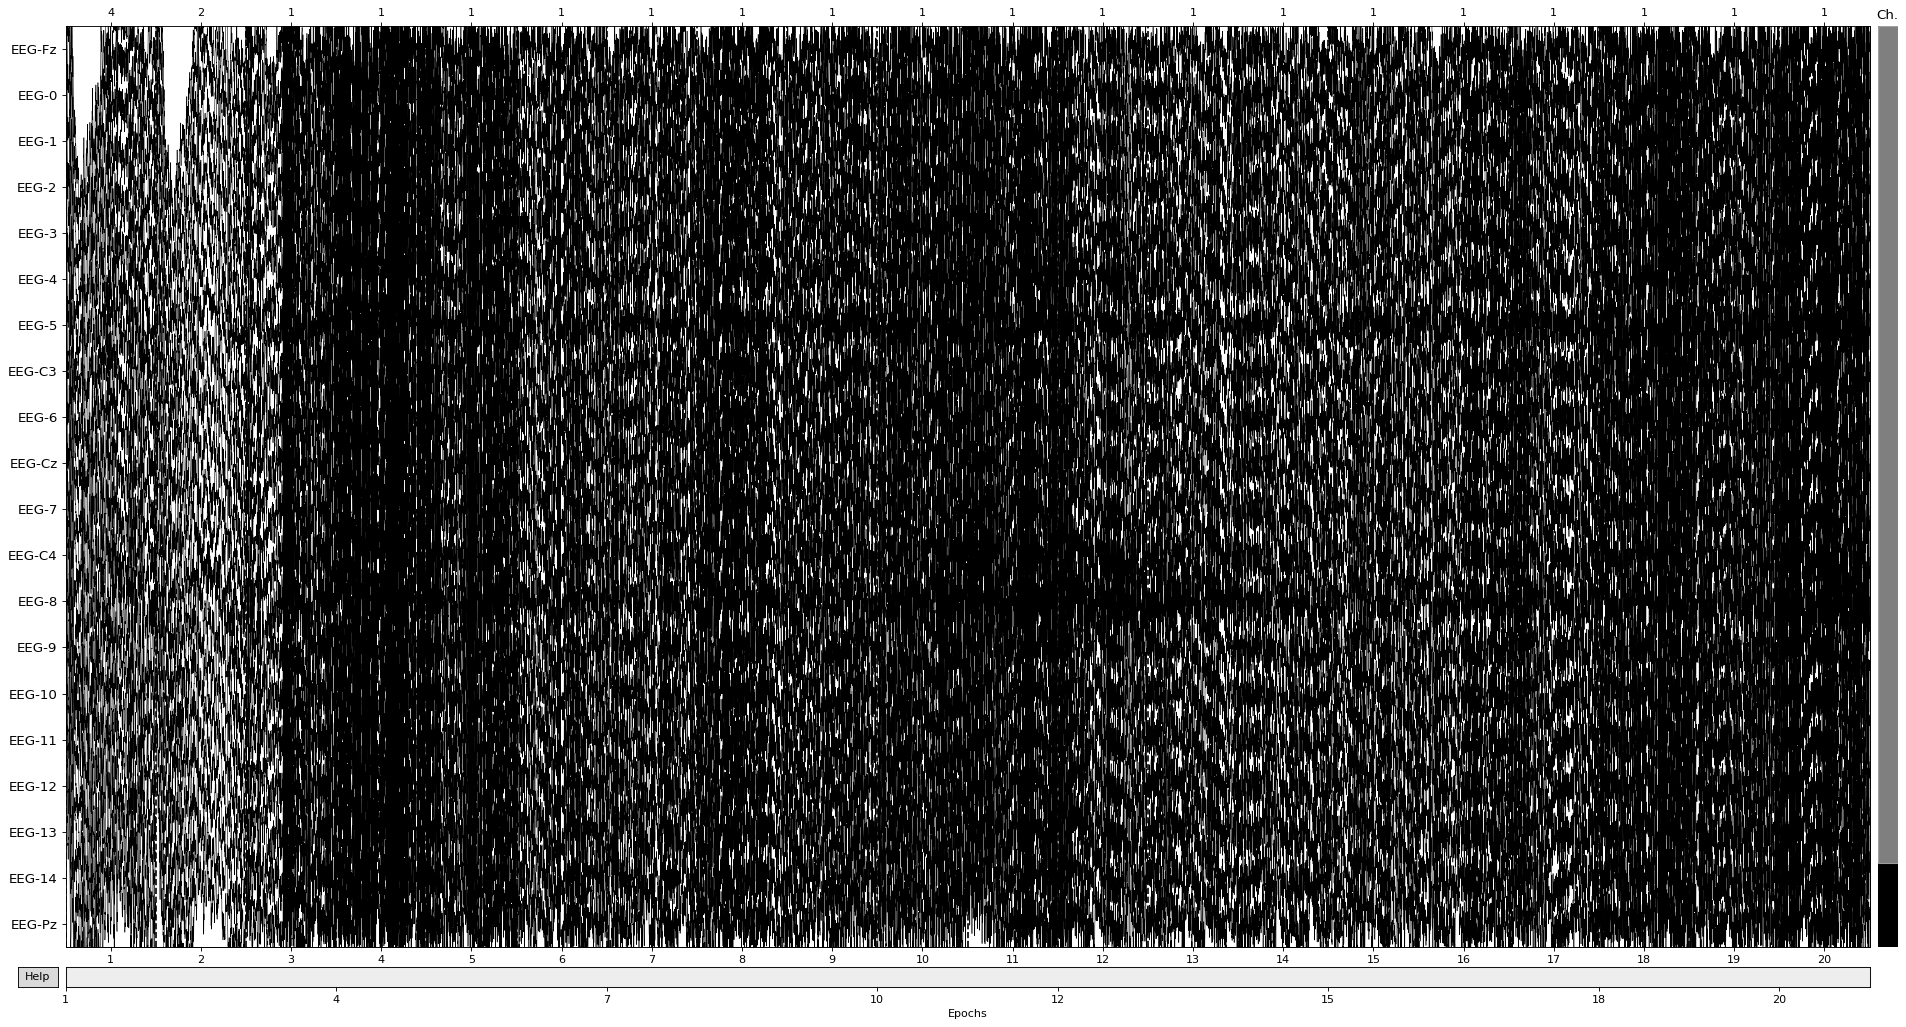

    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-51-c026fcb3c4d9>:3: DeprecationWarning: spatial_colors defaults to False in 0.19 but will change to True in 0.20. Set it explicitly to avoid this warning.
  epochs1.plot_psd(fmax=50)
<ipython-input-51-c026fcb3c4d9>:3: DeprecationWarning: average defaults to True in 0.19 but will change to False in 0.20. Set it explicitly to avoid this warning.
  epochs1.plot_psd(fmax=50)


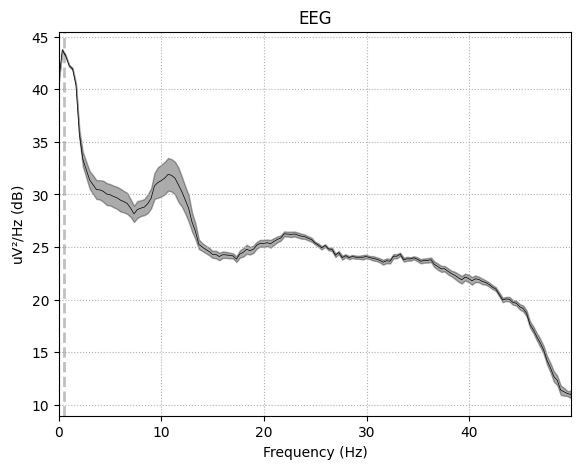

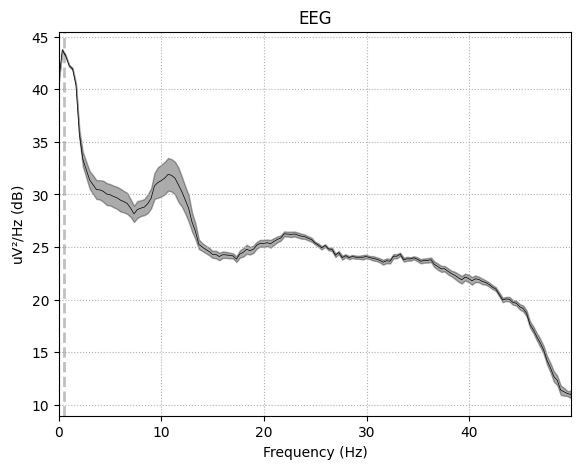

In [51]:
print(epochs1)
epochs1.plot()
epochs1.plot_psd(fmax=50)

In [18]:
def amplitude(x):
    """Data augmentation for adding noise to amplitude of sepctral image
    1 electrode คือ การดึงค่าคลื่นจาก electrode นั้นมา ซึ้่ง electrode นั้นคือ fc fz c4 c3 ประมาณนี้
    ----------
    X : array, shape (n_channels, n_times)
        The input signals.
    Returns
    -------
    X_t : array, shape (n_channels, n_times)
        reconstructed new time series from inverse STFT
    """
    print("Hello")



In [5]:
import torch   
import torch.optim as optim  
from torch.utils.data import Dataset, DataLoader  
from torch.utils.data import Subset  
from torch import nn  
import torch.nn.functional as F  
from torch.utils.data import RandomSampler  
from torch.utils.data import SequentialSampler  

from common import EpochsDataset  

cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data)
train_idx, test_idx = next(cv_split)


def scale(X):
    """Standard scaling of data along the last dimention.
    Parameters
    ----------
    X : array, shape (n_channels, n_times)
        The input signals.
    Returns
    -------
    X_t : array, shape (n_channels, n_times)
        The scaled signals.
    """
    return X / 2e-5

dataset = EpochsDataset(epochs_data, labels, transform=scale)

ds_train, ds_valid = Subset(dataset, train_idx), Subset(dataset, test_idx)

batch_size_train = len(ds_train)
batch_size_valid = len(ds_valid)
sampler_train = RandomSampler(ds_train)
sampler_valid = SequentialSampler(ds_valid)

# create loaders
num_workers = 0
loader_train = \
    DataLoader(ds_train, batch_size=batch_size_train,
               num_workers=num_workers, sampler=sampler_train)
loader_valid = \
    DataLoader(ds_valid, batch_size=batch_size_valid,
               num_workers=num_workers, sampler=sampler_valid)

In [6]:
class SingleNet(nn.Module):
    def __init__(self):
        super().__init__()

        # define model architecture
        # torch.Size([36, 1, 64, 256])
        # temporal convolutional kernel 25 filter with size(11,1)
        #input [224, 1, 22, 256]
        #A block
        self.temporalConv = nn.Conv1d(in_channels=1,out_channels=8,kernel_size=(11,1),stride=1)
        self.spatialConv = nn.Conv1d(in_channels=8,out_channels=8,kernel_size=(12,1),stride=1)
        self.maxPooling = nn.MaxPool2d((1,3))
        
        #B block
        # 1st convo output [25,1,371]
        #input [224, 8, 1, 85]
        self.firstConv = nn.Conv1d(in_channels=8, out_channels=8,kernel_size=(1,1))
        self.secondConv = nn.Conv1d(in_channels=8, out_channels=33,kernel_size=(1,1))
        self.thirdConv = nn.Conv1d(in_channels=33,out_channels=33,kernel_size=(1,1))
        self.maxPooling2 = nn.MaxPool2d((1,3))
        
        #C block
        #input [224, 41, 1, 28]
        self.classify = nn.Conv1d(in_channels=41,out_channels=41,kernel_size=(1,11))
        self.maxPooling3 = nn.MaxPool2d((1,3))
        self.flatten = nn.Flatten()
        self.elu = nn.ELU()
        self.fully = nn.Linear(246,4)
        
        
    def forward(self, x):
        #Conv1d(1,ch,kernel_size=10) on tensor [batch=1, channels=1, time=400]
        x = self.temporalConv(x)
        x= self.spatialConv(x)
        x = self.elu(x)
        x = self.maxPooling(x)
        
        out2 = self.firstConv(x)
        out2 = self.secondConv(out2)
        out2 = self.thirdConv(out2)
        out3 = torch.cat((x,out2),1)
        out3 = self.maxPooling2(out3)
        
        out3 = self.classify(out3)
        out3 = self.maxPooling3(out3)
        out3 = self.flatten(out3)
        out3 = self.elu(out3)
        out3 = self.fully(out3)
        out3 = self.elu(out3)
        out3 = F.log_softmax(out3, dim=1)
        
        return out3

In [7]:
#device = 'cuda'
device = 'cpu'
model = SingleNet()


In [8]:
# Train
from common import train

lr = 1e-4
n_epochs = 50
patience = 100

model.to(device=device) 
optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=1e-4)

train(model, loader_train, loader_valid, optimizer, n_epochs, patience, device)


Starting epoch 1 / 50


  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\asus\anaconda3\envs\tf_gpu\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
avg val loss: 1.3289: 100%|██████████| 1/1 [00:00<00:00, 29.49it/s]


---  Accuracy : 0.7678571343421936 


best val loss inf -> 1.3289

Starting epoch 2 / 50


avg val loss: 1.3031: 100%|██████████| 1/1 [00:00<00:00, 40.11it/s]


---  Accuracy : 0.9285714030265808 


best val loss 1.3289 -> 1.3031

Starting epoch 3 / 50


avg val loss: 1.2774: 100%|██████████| 1/1 [00:00<00:00, 52.77it/s]


---  Accuracy : 0.9642857313156128 


best val loss 1.3031 -> 1.2774

Starting epoch 4 / 50


avg val loss: 1.2518: 100%|██████████| 1/1 [00:00<00:00, 31.33it/s]


---  Accuracy : 0.9642857313156128 


best val loss 1.2774 -> 1.2518

Starting epoch 5 / 50


avg val loss: 1.2263: 100%|██████████| 1/1 [00:00<00:00, 35.81it/s]


---  Accuracy : 0.9642857313156128 


best val loss 1.2518 -> 1.2263

Starting epoch 6 / 50


avg val loss: 1.2009: 100%|██████████| 1/1 [00:00<00:00, 45.58it/s]


---  Accuracy : 0.9642857313156128 


best val loss 1.2263 -> 1.2009

Starting epoch 7 / 50


avg val loss: 1.1755: 100%|██████████| 1/1 [00:00<00:00, 45.58it/s]


---  Accuracy : 0.9642857313156128 


best val loss 1.2009 -> 1.1755

Starting epoch 8 / 50


avg val loss: 1.1503: 100%|██████████| 1/1 [00:00<00:00, 38.57it/s]


---  Accuracy : 0.9642857313156128 


best val loss 1.1755 -> 1.1503

Starting epoch 9 / 50


avg val loss: 1.1250: 100%|██████████| 1/1 [00:00<00:00, 40.11it/s]


---  Accuracy : 0.9642857313156128 


best val loss 1.1503 -> 1.1250

Starting epoch 10 / 50


avg val loss: 1.0998: 100%|██████████| 1/1 [00:00<00:00, 44.55it/s]


---  Accuracy : 0.9642857313156128 


best val loss 1.1250 -> 1.0998

Starting epoch 11 / 50


avg val loss: 1.0747: 100%|██████████| 1/1 [00:00<00:00, 41.78it/s]


---  Accuracy : 0.9642857313156128 


best val loss 1.0998 -> 1.0747

Starting epoch 12 / 50


avg val loss: 1.0496: 100%|██████████| 1/1 [00:00<00:00, 40.11it/s]


---  Accuracy : 0.9642857313156128 


best val loss 1.0747 -> 1.0496

Starting epoch 13 / 50


avg val loss: 1.0245: 100%|██████████| 1/1 [00:00<00:00, 35.81it/s]


---  Accuracy : 0.9642857313156128 


best val loss 1.0496 -> 1.0245

Starting epoch 14 / 50


avg val loss: 0.9995: 100%|██████████| 1/1 [00:00<00:00, 44.54it/s]


---  Accuracy : 0.9642857313156128 


best val loss 1.0245 -> 0.9995

Starting epoch 15 / 50


avg val loss: 0.9745: 100%|██████████| 1/1 [00:00<00:00, 52.77it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.9995 -> 0.9745

Starting epoch 16 / 50


avg val loss: 0.9496: 100%|██████████| 1/1 [00:00<00:00, 55.70it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.9745 -> 0.9496

Starting epoch 17 / 50


avg val loss: 0.9247: 100%|██████████| 1/1 [00:00<00:00, 52.78it/s]

---  Accuracy : 0.9642857313156128 


best val loss 0.9496 -> 0.9247



Starting epoch 18 / 50


avg val loss: 0.8999: 100%|██████████| 1/1 [00:00<00:00, 50.13it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.9247 -> 0.8999

Starting epoch 19 / 50


avg val loss: 0.8752: 100%|██████████| 1/1 [00:00<00:00, 50.13it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.8999 -> 0.8752

Starting epoch 20 / 50


avg val loss: 0.8506: 100%|██████████| 1/1 [00:00<00:00, 58.98it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.8752 -> 0.8506

Starting epoch 21 / 50


avg val loss: 0.8262: 100%|██████████| 1/1 [00:00<00:00, 62.67it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.8506 -> 0.8262

Starting epoch 22 / 50


avg val loss: 0.8019: 100%|██████████| 1/1 [00:00<00:00, 47.74it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.8262 -> 0.8019

Starting epoch 23 / 50


avg val loss: 0.7779: 100%|██████████| 1/1 [00:00<00:00, 27.85it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.8019 -> 0.7779

Starting epoch 24 / 50


avg val loss: 0.7541: 100%|██████████| 1/1 [00:00<00:00, 37.14it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.7779 -> 0.7541

Starting epoch 25 / 50


avg val loss: 0.7306: 100%|██████████| 1/1 [00:00<00:00, 38.57it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.7541 -> 0.7306

Starting epoch 26 / 50


avg val loss: 0.7074: 100%|██████████| 1/1 [00:00<00:00, 40.00it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.7306 -> 0.7074

Starting epoch 27 / 50


avg val loss: 0.6845: 100%|██████████| 1/1 [00:00<00:00, 41.78it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.7074 -> 0.6845

Starting epoch 28 / 50


avg val loss: 0.6620: 100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.6845 -> 0.6620

Starting epoch 29 / 50


avg val loss: 0.6400: 100%|██████████| 1/1 [00:00<00:00, 50.07it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.6620 -> 0.6400

Starting epoch 30 / 50


avg val loss: 0.6184: 100%|██████████| 1/1 [00:00<00:00, 40.83it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.6400 -> 0.6184

Starting epoch 31 / 50


avg val loss: 0.5973: 100%|██████████| 1/1 [00:00<00:00, 41.78it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.6184 -> 0.5973

Starting epoch 32 / 50


avg val loss: 0.5767: 100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.5973 -> 0.5767

Starting epoch 33 / 50


avg val loss: 0.5567: 100%|██████████| 1/1 [00:00<00:00, 54.40it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.5767 -> 0.5567

Starting epoch 34 / 50


avg val loss: 0.5372: 100%|██████████| 1/1 [00:00<00:00, 48.79it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.5567 -> 0.5372

Starting epoch 35 / 50


avg val loss: 0.5184: 100%|██████████| 1/1 [00:00<00:00, 45.58it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.5372 -> 0.5184

Starting epoch 36 / 50


avg val loss: 0.5002: 100%|██████████| 1/1 [00:00<00:00, 41.45it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.5184 -> 0.5002

Starting epoch 37 / 50


avg val loss: 0.4826: 100%|██████████| 1/1 [00:00<00:00, 45.58it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.5002 -> 0.4826

Starting epoch 38 / 50


avg val loss: 0.4657: 100%|██████████| 1/1 [00:00<00:00, 52.78it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.4826 -> 0.4657

Starting epoch 39 / 50


avg val loss: 0.4495: 100%|██████████| 1/1 [00:00<00:00, 58.98it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.4657 -> 0.4495

Starting epoch 40 / 50


avg val loss: 0.4339: 100%|██████████| 1/1 [00:00<00:00, 52.88it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.4495 -> 0.4339

Starting epoch 41 / 50


avg val loss: 0.4190: 100%|██████████| 1/1 [00:00<00:00, 58.98it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.4339 -> 0.4190

Starting epoch 42 / 50


avg val loss: 0.4048: 100%|██████████| 1/1 [00:00<00:00, 47.75it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.4190 -> 0.4048

Starting epoch 43 / 50


avg val loss: 0.3913: 100%|██████████| 1/1 [00:00<00:00, 50.13it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.4048 -> 0.3913

Starting epoch 44 / 50


avg val loss: 0.3785: 100%|██████████| 1/1 [00:00<00:00, 58.98it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.3913 -> 0.3785

Starting epoch 45 / 50


avg val loss: 0.3664: 100%|██████████| 1/1 [00:00<00:00, 58.98it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.3785 -> 0.3664

Starting epoch 46 / 50


avg val loss: 0.3549: 100%|██████████| 1/1 [00:00<00:00, 47.75it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.3664 -> 0.3549

Starting epoch 47 / 50


avg val loss: 0.3440: 100%|██████████| 1/1 [00:00<00:00, 45.58it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.3549 -> 0.3440

Starting epoch 48 / 50


avg val loss: 0.3338: 100%|██████████| 1/1 [00:00<00:00, 43.59it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.3440 -> 0.3338

Starting epoch 49 / 50


avg val loss: 0.3241: 100%|██████████| 1/1 [00:00<00:00, 47.75it/s]


---  Accuracy : 0.9642857313156128 


best val loss 0.3338 -> 0.3241

Starting epoch 50 / 50


avg val loss: 0.3151: 100%|██████████| 1/1 [00:00<00:00, 50.13it/s]

---  Accuracy : 0.9642857313156128 


best val loss 0.3241 -> 0.3151


SingleNet(
  (temporalConv): Conv1d(1, 8, kernel_size=(11, 1), stride=(1,))
  (spatialConv): Conv1d(8, 8, kernel_size=(12, 1), stride=(1,))
  (maxPooling): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
  (firstConv): Conv1d(8, 8, kernel_size=(1, 1), stride=(1,))
  (secondConv): Conv1d(8, 33, kernel_size=(1, 1), stride=(1,))
  (thirdConv): Conv1d(33, 33, kernel_size=(1, 1), stride=(1,))
  (maxPooling2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
  (classify): Conv1d(41, 41, kernel_size=(1, 11), stride=(1,))
  (maxPooling3): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (elu): ELU(alpha=1.0)
  (fully): Linear(in_features=246, out_features=4, bias=True)
)

In [9]:
# Test model works:

n_samples_test = 10
y_test = torch.randint(0, 2, (n_samples_test,))
y_pred = model.forward(torch.randn(n_samples_test, 1, *epochs_data.shape[1:]))
output = F.nll_loss(y_pred, y_test)
_, top_class = y_pred.topk(1, dim=1)


In [10]:
print(top_class)

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])
